In [50]:
import scipy.version as version
import numpy as np
import scipy.integrate as nint
import scipy.interpolate as interp
import scipy.stats as stats
import scipy.optimize as opt
import scipy.misc as mis
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
import math

%matplotlib inline

deg_k_smooth_spl = 5
extra_spl = 0 # 0 extrapolation , 1 zero; 2 error; 3 boundary values
def interp_spl(space, funct, der):
    tck = interp.splrep(space, funct, k=deg_k_smooth_spl, s=0)#, ext=extra_spl)
    return interp.splev(space, tck, der=der, ext=0)

interp_funct = lambda space, funct : interp.interp1d(space, funct, kind='cubic', fill_value='extrapolate')

logit = lambda x: np.log(np.abs(x))

The flat metric in spherical coordinates is

$\mathrm{d}s^2 = -\mathrm{d}t^2 + \mathrm{d}r^2 + r^2\mathrm{d}\theta^2 + r^2\sin^2\theta\,\mathrm{d}\phi^2$,

and the matter Lagrangian is a free scalar field,

$\mathcal{L}_{\text{matter}} = -(\partial_\mu \Phi + ie A_\mu\Phi)(\partial^\mu \Phi^* - ie A^\mu\Phi^*)-\lambda (|\Phi|^2-v^2)^2-\frac{1}{4}|F_{\mu\nu}|^2$. We also decompose the complex scalar $\Phi$ to two real scalars $\Phi = \frac{1}{\sqrt{2}}(\phi_1 + i\phi_2)$ when simulation is needed.

We use the radiation gauge $\mathbf{k}\cdot\mathbf{A}=0$ and spherical symmetry to set $A_\mu = (a,0,0,0)$, where the only non-vanishing component is $A_t=a$.

1. $\dot{\Phi} = p - iqa\Phi$,

2. $a' = g$

3. $\dot{p} = \frac{1}{r^2}\partial_r(r^2\Phi')-2\lambda \Phi^*(|\Phi|^2-v^2) -iqap$,

4. $\dot{g} = iq(\Phi\Phi^*\,\!' - \Phi^* \Phi') = q(\phi_1 \phi_2' - \phi_1'\phi_2) $

In [51]:
r_min = 0.5
r_max = 50.
r_div = int(1e2)

rr = np.linspace(r_min, r_max, r_div)
print("spatial step size = ", str((r_max-r_min)/r_div))

spatial step size =  0.495


In [52]:
def df_dx(x, f, n_bnd=None):
    delta_x = x[1]-x[0]
    #x_plus = x+delta_x; x_minus = x-delta_x
    x_plus = x+delta_x
    if n_bnd is None:
        f_dx = (f(x_plus) - f(x))/delta_x
    else:
        f_dx = (f(x_plus[:-1]) - f(x[:-1]))/delta_x
        f_bnd = f_dx[-1]*(x_plus[-1]/x[-1])**(n_bnd-1)
        f_dx = np.hstack((f_dx, f_bnd))
    return f_dx

def ddf_dxdx(x, f, n_bnd=None):
    delta_x = x[1]-x[0]
    #x_plus = x+delta_x; x_minus = x-delta_x
    x_plus = x+delta_x; x_plus_2 = x + 2*delta_x; x_plus_3 = x + 3*delta_x
    if n_bnd is None:
        f_dxdx = (2.*f(x) -5.*f(x_plus) + 4.*f(x_plus_2) - f(x_plus_3))/(delta_x**2)    
    else:   
        f_dxdx = ( 2*f(x[:-3]) - 5.*f(x_plus[:-3]) + 4.*f(x_plus_2[:-3]) - f(x_plus_3[:-3]) )/(delta_x**2)
        f_bnd_1 = (f_dxdx[-1])*(x_plus[-1]/x[-1])**(n_bnd-2)
        f_bnd_2 = (f_dxdx[-1])*(x_plus_2[-1]/x[-1])**(n_bnd-2)
        f_bnd_3 = (f_dxdx[-1])*(x_plus_3[-1]/x[-1])**(n_bnd-2)
        f_dxdx = np.hstack(( f_dxdx, f_bnd_1, f_bnd_2, f_bnd_3 ))
    return f_dxdx


# Scalar only equation in field polar coordinates


$\dot{\rho} = \frac{N}{\psi^6}k$,

$\dot{\alpha} = \frac{N}{\psi^6}\beta - qA_t$,

$\dot{k} = \frac{1}{r^2}\partial_r(r^2N\psi^2\rho') + \frac{N}{\psi^6}\rho\beta^2 - N\psi^2\rho\alpha^{\prime 2} - N\psi^6\frac{{\rm d}V(\rho)}{{\rm d}\,{\rho}}$,

$\dot{\beta} = -2\frac{N}{\psi^6}\beta\frac{k}{\rho} + 2N\psi^2\alpha'\frac{\rho'}{\rho}+\frac{1}{r^2}\partial_r(r^2N\psi^2\alpha')$.

In [53]:
m_X = 1.
lamb = 1.
q = 1.0 # Set = 1. In coordinates rescaled by gauge coupling q, the factor q drops from all equations.


def pot(t,rho):
    return -m_X**2*rho + lamb*rho**3

def drho_dt(k):
    return k
    
def dalpha_dt(beta,gauge):
    beta_dt = beta - gauge
    return beta_dt

def dk_dt(r, beta, rho, alpha_dr, rho_dr, rho_drdr, t):
    k_dt = 2.*rho_dr/r + rho_drdr + rho*beta**2 - rho*alpha_dr**2 - pot(t,rho)
    return k_dt

def dbeta_dt(r, k, beta, rho, alpha_dr, rho_dr, alpha_drdr, t):
    if (t == dt):# or (t == 2.*dt) or (t == 3.*dt):
        return -2.*np.ones_like(r)*m_X*beta
    beta_dt = -2.*beta*k/rho + 2.*alpha_dr*rho_dr/rho + 2.*alpha_dr/r + alpha_drdr
    return beta_dt

def dc_dt(r,rho,alpha_dr):
    c_dt = r**2*rho**2*alpha_dr
    return c_dt

def raddev(r,field,n):
    field_dr_n = interp_spl(r,field,der=n)
    return field_dr_n

def update_gauge(r,c):    
    return 0    

In [78]:
def fun_t(r, y, dt, t, verbose=False):
    
    rho_in = y[0]; alpha_in = y[1];  k_in = y[2]; beta_in = y[3];
    gauge_in = y[4];
    
    
    # First half-step
    
    rho_grid_in = rho_in(r)
    alpha_grid_in = alpha_in(r)
    k_grid_in = k_in(r)
    beta_grid_in = beta_in(r)

    rho_dr_in = raddev(r, rho_grid_in, 1)
    alpha_dr_in = raddev(r, alpha_grid_in, 1)
    
    rho_drdr_in = raddev(r, rho_grid_in, 2)
    alpha_drdr_in = raddev(r, alpha_grid_in, 2)
    
    gauge_grid_in = gauge_in(r)
    c_grid_in = r**2 * raddev(r, gauge_grid_in, 1)
    
    rho_grid_mp = rho_grid_in + 0.5*dt*drho_dt(k_grid_in)
    alpha_grid_mp = alpha_grid_in + 0.5*dt*dalpha_dt(beta_grid_in, gauge_grid_in)
    k_grid_mp = k_grid_in + 0.5*dt*dk_dt(r, beta_grid_in, rho_grid_in, alpha_dr_in, rho_dr_in, rho_drdr_in, t)
    beta_grid_mp = beta_grid_in + 0.5*dt*dbeta_dt(r, k_grid_in, beta_grid_in, rho_grid_in, alpha_dr_in, rho_dr_in, alpha_drdr_in, t)
    
    c_grid_mp = c_grid_in + 0.5*dt*dc_dt(r,rho_grid_in,alpha_dr_in)
    gauge_grid_mp =
    
    # Second half-step
    
    rho_mp = interp_funct(r, rho_grid_mp)
    alpha_mp = interp_funct(r, alpha_grid_mp)
    
    rho_dr_mp = raddev(r, rho_grid_mp, 1)
    alpha_dr_mp = raddev(r, alpha_grid_mp, 1)
    
    rho_drdr_mp = raddev(r, rho_grid_mp, 2)
    alpha_drdr_mp = raddev(r, alpha_grid_mp, 2)
    
    gauge_mp = gauge_grid_mp
    c_mp = interp_funct(r,c_grid_mp)
    
    rho_grid_out = rho_grid_in + dt*drho_dt(k_grid_mp)
    alpha_grid_out = alpha_grid_in + dt*dalpha_dt(beta_grid_mp,gauge_mp)
    k_grid_out = k_grid_in + dt*dk_dt(r, beta_grid_mp, rho_grid_mp, alpha_dr_mp, rho_dr_mp, rho_drdr_mp, t)
    beta_grid_out = beta_grid_in + dt*dbeta_dt(r, k_grid_mp, beta_grid_mp, rho_grid_mp, alpha_dr_mp, rho_dr_mp, alpha_drdr_mp, t)
    
    c_grid_out = c_grid_mp + dt*dc_dt(r,rho_grid_mp,alpha_dr_mp)
    gauge_grid_out = gauge_mp
    
    alpha_dr_out = raddev(r, alpha_grid_out, 1)
    charge_ap = interp_funct(r,rho_grid_out**2*alpha_dr_out)
    
    rho_out = interp_funct(r, rho_grid_out)
    alpha_out = interp_funct(r, alpha_grid_out)
    k_out = interp_funct(r, k_grid_out)
    beta_out = interp_funct(r, beta_grid_out)
    gauge_out = interp_funct(r,gauge_grid_out)
    c_out = interp_funct(r,c_grid_out)
     
    return [rho_out, alpha_out, k_out, beta_out,gauge_out,charge_ap,c_out]

In [79]:
rho_init = interp_funct(rr, np.zeros_like(rr))
alpha_init = interp_funct(rr, np.zeros_like(rr))
k_init = interp_funct(rr, 1e-1*np.ones_like(rr))
#beta_init = interp_funct(rr, -1e-1*np.ones_like(rr))
beta_init = interp_funct(rr, np.zeros_like(rr))
gauge_init = interp_funct(rr, -1./rr)
charge_init = interp_funct(rr,np.zeros_like(rr))
c_init = interp_funct(rr,np.ones_like(rr))

t_end =1000
dt = 0.01

t_range = range(0,t_end)

vec_t = [rho_init, alpha_init, k_init, beta_init,gauge_init,charge_init,c_init]
t_all = np.array(vec_t)
t_size = np.array([0.])
t_now = t_size[-1]

for t_step in tqdm(range(0,t_end)):
    t_now = t_size[-1]+dt
    vec_t = fun_t(rr, vec_t, dt, t_now)
    t_all = np.vstack((t_all, vec_t))
    t_size = np.hstack((t_size, t_now))

 71%|███████▏  | 713/1000 [00:01<00:00, 389.90it/s]C:\Users\rxsim\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\rxsim\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in add
C:\Users\rxsim\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in multiply
C:\Users\rxsim\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in power
  import sys
C:\Users\rxsim\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in subtract
100%|██████████| 1000/1000 [00:02<00:00, 398.45it/s]


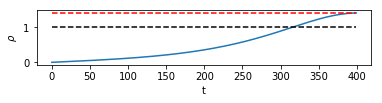

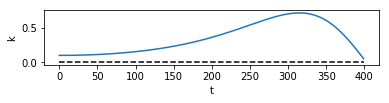

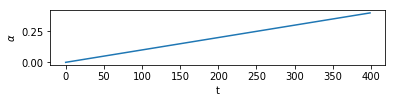

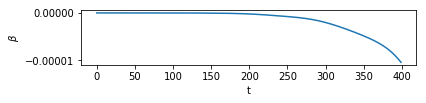

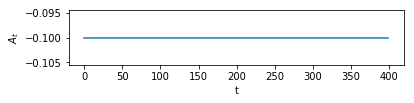

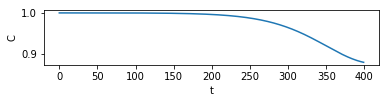

In [83]:
r_min_plot = r_min
r_max_plot = r_max

plot_t_range = range(0,400,1)#t_end)

result = np.array(t_all)

rho_result = result[:, 0];
alpha_result = result[:,1];
k_result = result[:,2];
beta_result = result[:,3];
gauge_result = result[:,4];
c_result = result[:,6];
charge_res = result[:,5];

rho_vec = np.array([])
k_vec = np.array([])
alpha_vec = np.array([])
beta_vec = np.array([])
gauge_vec = np.array([])
c_vec = np.array([])
charge_vec = np.array([])

r_to_plot = 10
#print(plot_t_range[-1])

for t_i in plot_t_range:
    rho_vec = np.append(rho_vec, rho_result[t_i](r_to_plot))
    k_vec = np.append(k_vec, k_result[t_i](r_to_plot))
    alpha_vec = np.append(alpha_vec, alpha_result[t_i](r_to_plot))
    beta_vec = np.append(beta_vec, beta_result[t_i](r_to_plot))
    gauge_vec = np.append(gauge_vec, gauge_result[t_i](r_to_plot))
    c_vec = np.append(c_vec, c_result[t_i](r_to_plot))
    charge_vec = np.append(charge_vec, charge_res[t_i](r_to_plot))
    
plt.figure(figsize=(6,1))
plt.plot(plot_t_range, rho_vec);
plt.plot(plot_t_range,np.ones_like(plot_t_range),'k--')
plt.plot(plot_t_range, np.sqrt(2)*np.ones_like(plot_t_range),'r--')
plt.ylabel("$\\rho$");plt.xlabel("t")
plt.show()
plt.figure(figsize=(6,1))
plt.plot(plot_t_range, k_vec);
plt.plot(plot_t_range, np.zeros_like(plot_t_range),'k--')
plt.ylabel("k");plt.xlabel("t")
plt.show()
plt.figure(figsize=(6,1))
plt.plot(plot_t_range, alpha_vec);
plt.ylabel("$\\alpha$");plt.xlabel("t")
#plt.yscale("symlog")
plt.show()
plt.figure(figsize=(6,1))
plt.plot(plot_t_range, beta_vec);
plt.ylabel("$\\beta$");plt.xlabel("t")
#plt.yscale("symlog")
plt.show()
plt.figure(figsize=(6,1))
plt.plot(plot_t_range, gauge_vec);
plt.ylabel("$A_t$");plt.xlabel("t")
#plt.yscale("symlog")
plt.show()
plt.figure(figsize=(6,1))
plt.plot(plot_t_range, c_vec);
plt.ylabel("C");plt.xlabel("t")
#plt.yscale("symlog")
plt.show()

#time_range = range(10,1000,100)

#print("length of time steps: ", len(t_all))
#plot_t_slice_fields(t_all, time_range, rr_plot, log=False)

In [85]:
plot_alpha = 0.7

def plot_t_slice_fields(t_all, t_slices, r, log=False):
    result = np.array(t_all)[t_slices]
    rho_result = result[:,0]; alpha_result = result[:,1]; k_result = result[:,2]; beta_result = result[:,3];gauge_result = result[:,4];c_result = result[:,6];
    grey_scale_color = np.linspace(0.0, 0.8, len(t_slices))

    fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(20,10))
    plt.subplots_adjust(wspace = 0.2, hspace=0.5)
    for row in ax:
        for col in row:
           col.set_xlabel('$r$')
           col.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

    for i, t_slice in enumerate(t_slices):
        if log:
            ax[0,0].plot(r, logit(rho_result[i](r)), label=('t = ' + str(t_slice)), color=str(grey_scale_color[i]), alpha=plot_alpha)
        else:
            ax[0,0].plot(r, rho_result[i](r), label=('t = ' + str(t_slice)), color=str(grey_scale_color[i]), alpha=plot_alpha)
    ax[0,0].set_ylabel('$\\rho$'); #ax[0,0].legend();
        
    for i, t_slice in enumerate(t_slices):
        if log:
            ax[1,0].plot(r, logit(k_result[i](r)), label=('t = ' + str(t_slice)), color=str(grey_scale_color[i]), alpha=plot_alpha)
        else:
            ax[1,0].plot(r, k_result[i](r), label=('t = ' + str(t_slice)), color=str(grey_scale_color[i]), alpha=plot_alpha)
    ax[1,0].set_ylabel('$k$'); #ax[1,1].legend();

    for i, t_slice in enumerate(t_slices):
        if log:
            ax[0,1].plot(r, logit(alpha_result[i](r)), label=('t = ' + str(t_slice)), color=str(grey_scale_color[i]), alpha=plot_alpha)
        else:
            ax[0,1].plot(r, alpha_result[i](r), label=('t = ' + str(t_slice)), color=str(grey_scale_color[i]), alpha=plot_alpha)
    ax[0,1].set_ylabel('$\\alpha$'); #ax[1,0].legend();
    
    for i, t_slice in enumerate(t_slices):
        if log:
            ax[1,1].plot(r, logit(beta_result[i](r)), label=('t = ' + str(t_slice)), color=str(grey_scale_color[i]), alpha=plot_alpha)
        else:
            ax[1,1].plot(r, beta_result[i](r), label=('t = ' + str(t_slice)), color=str(grey_scale_color[i]), alpha=plot_alpha)
    ax[1,1].set_ylabel('$\\beta$'); #ax[0,0].legend();
    
    for i, t_slice in enumerate(t_slices):
        if log:
            ax[2,0].plot(r, logit(gauge_result[i](r)), label=('t = ' + str(t_slice)), color=str(grey_scale_color[i]), alpha=plot_alpha)
        else:
            ax[2,0].plot(r, gauge_result[i](r), label=('t = ' + str(t_slice)), color=str(grey_scale_color[i]), alpha=plot_alpha)
    ax[2,0].set_ylabel('$A_t$'); #ax[0,0].legend();
    
    for i, t_slice in enumerate(t_slices):
        if log:
            ax[2,1].plot(r, logit(c_result[i](r)), label=('t = ' + str(t_slice)), color=str(grey_scale_color[i]), alpha=plot_alpha)
        else:
            ax[2,1].plot(r, c_result[i](r), label=('t = ' + str(t_slice)), color=str(grey_scale_color[i]), alpha=plot_alpha)
    ax[2,1].set_ylabel('C'); #ax[0,0].legend();
    

    print("Matter field contents")
    plt.show()

length of time steps:  1001
Matter field contents


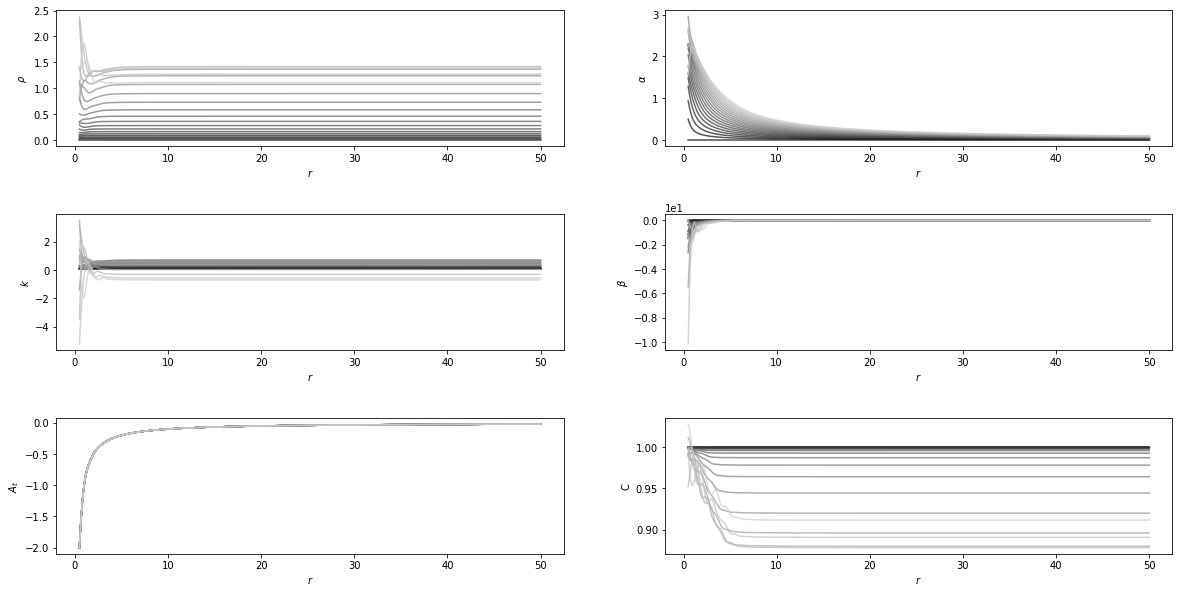

In [88]:
r_min_plot = r_min
r_max_plot = r_max

rr_plot = np.linspace(r_min_plot, r_max_plot, 300)
time_range = range(0,500,25)
result = t_all

print("length of time steps: ", len(t_all))
plot_t_slice_fields(result, time_range, rr_plot, log=False)